In [1]:
%pylab inline
import numpy as np

Populating the interactive namespace from numpy and matplotlib


# Read the data

Function for reading ECG signals from a file

In [2]:
def read_X(filename):
    X = list()
    with open(filename) as f:
        while True:
            line = f.readline()
            if not line:
                break
            amplitudes = [int(x) for x in line.strip().split(',')]
            intervals = [int(x) for x in f.readline().strip().split(',')]
            
            f.readline() # skip an empty line
            X.append((amplitudes, intervals))
    return X

Read ECG signals of the train and test set

In [3]:
X_train_ecg = read_X('X.train.csv')
X_test_ecg = read_X('X.test.csv')
print len(X_train_ecg), len(X_test_ecg)

900 903


Read labels of the train set

In [4]:
y_train = list()
for line in open('y.train.csv'):
    y_train.append(int(line))
print len(y_train)

900


# Create trigram representation

Function for discretization of the ECG signals into 6 values (6 letters)

In [5]:
def discretize(X):
    discrete = list()
    for amps, ints in X:
        amps = np.array(amps).astype(float)
        ints = np.array(ints).astype(float)
        alphas = arctan(amps / ints)

        amps = diff(amps)
        ints = diff(ints)
        alphas = diff(alphas)

        s = list()
        for ind, r, t, a in zip(range(600), amps, ints, alphas):
            c = 'x'
            if r > 0 and t > 0 and a > 0:
                c = 'a'
            if r <= 0 and t <= 0 and a > 0:
                c = 'b'
            if r > 0 and t <= 0 and a > 0:
                c = 'c'
            if r <= 0 and t > 0 and a <= 0:
                c = 'd'
            if r > 0 and t > 0 and a <= 0:
                c = 'e'
            if r <= 0 and t <= 0 and a <= 0:
                c = 'f'
            if c == 'x':
                print 'Very strange!!!', ind, r, t, a
            s.append(c)

        discrete.append(s)
    return discrete

Apply it to our data. RuntimeWarning is fine, because of zeros in intervals. 

In [6]:
X_train_discrete = discretize(X_train_ecg)
X_test_discrete = discretize(X_test_ecg)
print len(X_train_discrete), len(X_test_discrete)

900 903


/Users/arshakminasyan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in divide


Function for counting trigrams and saving it in the numpy array format

In [7]:
from collections import defaultdict
from itertools import product

def vectorize(discrete):
    vectorized = list()
    for element in discrete:
        current = defaultdict(int)
        for j in range(597):
            current[tuple(element[j:j+3])] += 1

        vect = list()
        for a, b, c in product('abcdef', 'abcdef', 'abcdef'):
            vect.append(current[(a, b, c)])
        vectorized.append(vect)
    return array(vectorized).astype(float)

Create final train and test matrices

In [8]:
X_train = vectorize(X_train_discrete)
X_test = vectorize(X_test_discrete)
print X_train.shape, X_test.shape

(900, 216) (903, 216)


# Machine learning

Use 5-fold crossvalidation for finding optimal K in KNN

In [9]:
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import roc_auc_score

params = {'n_neighbors': arange(1, 200, 1)}
for k in range(1, 10):
    grid_searcher = GridSearchCV(KNN(),\
                             params, cv=k, scoring='roc_auc', n_jobs=3)
grid_searcher.fit(X_train, y_train)
print grid_searcher.best_score_
print grid_searcher.best_estimator_
print grid_searcher.best_params_
print grid_searcher.fit_params

0.955271967319
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=36, p=2,
           weights='uniform')
{'n_neighbors': 36}
{}


In [10]:
print grid_searcher.best_estimator_.fit

<bound method KNeighborsClassifier.fit of KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=36, p=2,
           weights='uniform')>


Function for plotting the results

In [11]:
def plot_quality(grid_searcher, param_name):
    means = []
    stds = []
    for elem in grid_searcher.grid_scores_:
        means.append(mean(elem.cv_validation_scores))
        stds.append(sqrt(var(elem.cv_validation_scores)))
    means = array(means)
    stds = array(stds)
    
    params = grid_searcher.param_grid
    
    figure(figsize=(8, 6))
    plot(params[param_name], means)
    fill_between(params[param_name], \
                 means + stds, means - stds, alpha = 0.3, facecolor='blue')
    xlabel(param_name)
    ylabel('AUC')

Plot results

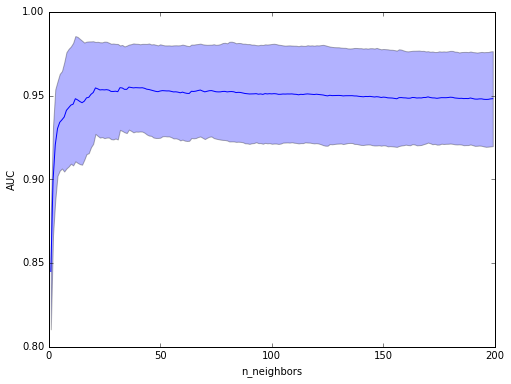

In [12]:
plot_quality(grid_searcher, 'n_neighbors')

Save the results in the proper format

In [13]:
clf = grid_searcher.best_estimator_.fit(X_train, y_train)
results = clf.predict_proba(X_test)[:, 1]
f = open('y.test.baseline.csv', 'w')
print >> f, 'Id,Prediction'
for i, result in enumerate(results):
    print >> f, str(i+1) + ',' + str(result)
f.close()